###Here below is function for all the regions we want for 3 actually

In [3]:
import requests
import time
import pandas as pd
from datetime import datetime
import os
from dotenv import load_dotenv

# Load API key from .env
load_dotenv()
API_KEY = os.getenv("OPENAQ_API_KEY")
if not API_KEY:
    raise ValueError("Environment variable 'OPENAQ_API_KEY' is missing.")

BASE_URL = "https://api.openaq.org/v3"
REQUEST_DELAY = 1.1  # seconds

def safe_request(url, params=None):
    while True:
        try:
            r = requests.get(url, headers={"X-API-Key": API_KEY}, params=params)
            if r.status_code == 429:
                print("429 Too Many Requests — waiting 10 seconds...")
                time.sleep(10)
                continue
            r.raise_for_status()
            return r.json()
        except requests.exceptions.RequestException as e:
            print(f"Request error: {e}")
            time.sleep(5)

def get_all_locations(bbox):
    url = f"{BASE_URL}/locations"
    params = {"bbox": bbox, "limit": 1000}
    return safe_request(url, params)["results"]

def get_pm25_sensor_ids(locations):
    sensor_ids = []
    for loc in locations:
        for sensor in loc.get("sensors", []):
            if sensor["parameter"]["name"] == "pm25":
                sensor_ids.append(sensor["id"])
    return sensor_ids

def get_monthly_pm25(sensor_id):
    url = f"{BASE_URL}/sensors/{sensor_id}/days/monthly"
    params = {
        "date_from": "2018-01-01T00:00:00Z",
        "date_to": "2023-12-31T23:59:59Z",
        "limit": 1000
    }
    results = safe_request(url, params).get("results", [])
    data = []
    for item in results:
        period = item["period"]["datetimeFrom"]["utc"]
        dt = datetime.fromisoformat(period.replace("Z", "+00:00"))
        data.append({
            "sensor_id": sensor_id,
            "year": dt.year,
            "month": dt.month,
            "value": item["value"]
        })
    return data

def process_region(region_name, bbox):
    print(f"\nProcessing region: {region_name}")
    locations = get_all_locations(bbox)
    print(f"Found {len(locations)} stations")

    sensor_ids = get_pm25_sensor_ids(locations)
    print(f"Found {len(sensor_ids)} PM2.5 sensors")

    all_data = []
    for i, sensor_id in enumerate(sensor_ids, 1):
        print(f"Processing sensor {i}/{len(sensor_ids)}: ID={sensor_id}")
        time.sleep(REQUEST_DELAY)
        sensor_data = get_monthly_pm25(sensor_id)
        for row in sensor_data:
            row["region"] = region_name
        all_data.extend(sensor_data)

    df = pd.DataFrame(all_data)
    if df.empty:
        print("No PM2.5 data available for this region.")
        return pd.DataFrame()

    summary = (
        df.groupby(["region", "year", "month"])
        .agg(avg_value=("value", "mean"), sensor_count=("value", "count"))
        .reset_index()
        .sort_values(by=["region", "year", "month"])
    )

    filename = f"{region_name.lower().replace(' ', '_')}_pm25_monthly_2018_2023.csv"
    summary.to_csv(filename, index=False)
    print(f"Data saved to file: {filename}")
    print(summary.head())

    return summary

if __name__ == "__main__":
    regions = {
        
        "Auvergne-Rhône-Alpes": "3.0,44.0,7.4,46.4",
        "Île-de-France": "1.45,48.0,3.6,49.2"
    }

    combined_df = pd.DataFrame()

    for region_name, bbox in regions.items():
        region_df = process_region(region_name, bbox)
        if not region_df.empty:
            combined_df = pd.concat([combined_df, region_df], ignore_index=True)

    print("\nCombined DataFrame (first rows):")
    print(combined_df.head())



Processing region: Auvergne-Rhône-Alpes
Found 127 stations
Found 57 PM2.5 sensors
Processing sensor 1/57: ID=5614
Processing sensor 2/57: ID=8534
Processing sensor 3/57: ID=5597
Processing sensor 4/57: ID=5610
Processing sensor 5/57: ID=8559
Processing sensor 6/57: ID=7854
Processing sensor 7/57: ID=7922
Processing sensor 8/57: ID=13053058
Processing sensor 9/57: ID=10182727
Processing sensor 10/57: ID=24867
Processing sensor 11/57: ID=8051
Processing sensor 12/57: ID=8056
Processing sensor 13/57: ID=8067
Processing sensor 14/57: ID=26008
Processing sensor 15/57: ID=10182729
Processing sensor 16/57: ID=1314203
Processing sensor 17/57: ID=4445297
Processing sensor 18/57: ID=40613
Processing sensor 19/57: ID=40645
Processing sensor 20/57: ID=8313
Processing sensor 21/57: ID=8330
Processing sensor 22/57: ID=8360
Processing sensor 23/57: ID=40625
Processing sensor 24/57: ID=8372
Processing sensor 25/57: ID=8404
Processing sensor 26/57: ID=8409
Processing sensor 27/57: ID=8473
Processing s

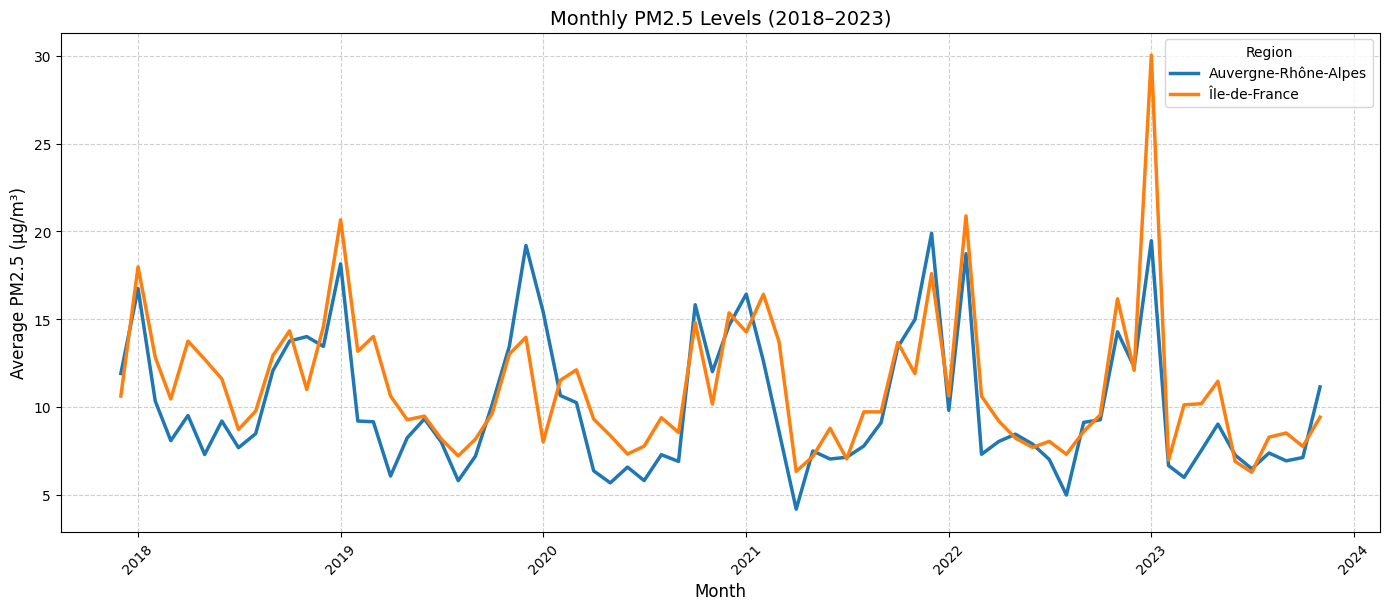

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a datetime column combining 'year' and 'month'
combined_df["year_month"] = pd.to_datetime(combined_df["year"].astype(str) + "-" + combined_df["month"].astype(str))

# Initialize the plot
plt.figure(figsize=(14, 6))

# Plot PM2.5 trends for each region with thicker lines
for region in combined_df["region"].unique():
    region_data = combined_df[combined_df["region"] == region]
    plt.plot(region_data["year_month"], region_data["avg_value"], label=region, linewidth=2.5)

# Set plot title and axis labels
plt.title("Monthly PM2.5 Levels (2018–2023)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average PM2.5 (µg/m³)", fontsize=12)

# Display legend and grid
plt.legend(title="Region")
plt.grid(True, linestyle='--', alpha=0.6)

# Improve layout and rotate x-axis labels
plt.tight_layout()
plt.xticks(rotation=45)

# Show the final plot
plt.show()



In [ ]:
import pandas as pd
import numpy as np

def load_and_clean_data(filepath):
    df = pd.read_csv(filepath, encoding='latin1', sep=';', parse_dates=['jour'])
    df = df.rename(columns={
        'jour': 'day',
        'nomReg': 'region',
        'incid_rea': 'number_of_cases'
    })
    df = df.drop(columns=['numReg'])
    return df

def fix_region_names(df):
    df.loc[df['region'] == 'Ile-de-France', 'region'] = 'Île-de-France'
    return df

def filter_mainland_regions(df):
    overseas = ['Guadeloupe', 'Martinique', 'Guyane', 'La Réunion', 'Mayotte']
    df = df[~df['region'].isin(overseas)]
    df = df[df['region'].notna()].reset_index(drop=True)
    return df

def add_time_columns(df):
    df['year'] = df['day'].dt.year
    df['month'] = df['day'].dt.month
    return df

def compute_monthly_cases(df):
    return df.groupby(['region', 'year', 'month'])['number_of_cases'].sum().reset_index()

def compute_monthly_changes(monthly_df):
    monthly_df['change_in_cases'] = monthly_df.groupby(['region', 'year'])['number_of_cases'].diff().fillna(0)
    return monthly_df

def filter_year_data(df, year):
    return df[df['year'] == year]


def compute_region_abs_change(df):
    return df.groupby('region')['change_in_cases'].agg(
        sum_abs_change=lambda x: np.sum(np.abs(x))
    ).reset_index()

def main():
    filepath = "./data/file.csv"
    
    cases_france = load_and_clean_data(filepath)
    cases_france = filter_mainland_regions(cases_france)
    cases_france = add_time_columns(cases_france)
    
    monthly_cases = fix_region_names(cases_france)
    monthly_cases = compute_monthly_cases(cases_france)
    monthly_cases = compute_monthly_changes(monthly_cases)
    
    
    return cases_france, monthly_cases

cases_france, monthly_cases = main()

cases_france
monthly_cases
print(monthly_cases['region'].unique())


['Auvergne-Rhône-Alpes' 'Bourgogne-Franche-Comté' 'Bretagne'
 'Centre-Val de Loire' 'Corse' 'Grand-Est' 'Hauts-de-France' 'Normandie'
 'Nouvelle-Aquitaine' 'Occitanie' 'Pays de la Loire'
 "Provence-Alpes-Côte d'Azur" 'Île-de-France']


In [7]:

monthly_cases['region'] = monthly_cases['region'].str.lower().str.strip()
combined_df['region'] = combined_df['region'].str.lower().str.strip()

merged_df = pd.merge(
    monthly_cases,
    combined_df,
    on=['region', 'year', 'month'],
    how='inner'  
)

print(merged_df.head())

merged_df

print(merged_df['region'].unique())


                 region  year  month  number_of_cases  change_in_cases  \
0  auvergne-rhône-alpes  2020      3              796              0.0   
1  auvergne-rhône-alpes  2020      4              847             51.0   
2  auvergne-rhône-alpes  2020      5              156           -691.0   
3  auvergne-rhône-alpes  2020      6               28           -128.0   
4  auvergne-rhône-alpes  2020      7               25             -3.0   

   avg_value  sensor_count year_month  
0  10.249545            22 2020-03-01  
1   6.367619            21 2020-04-01  
2   5.680909            22 2020-05-01  
3   6.581364            22 2020-06-01  
4   5.813043            23 2020-07-01  
['auvergne-rhône-alpes' 'île-de-france']


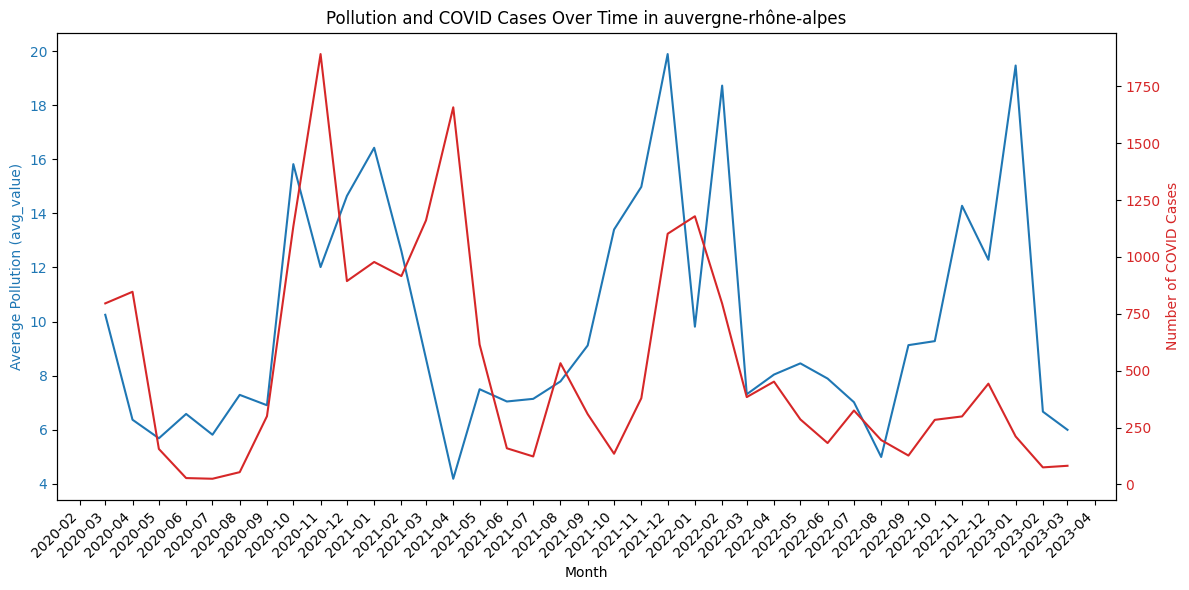

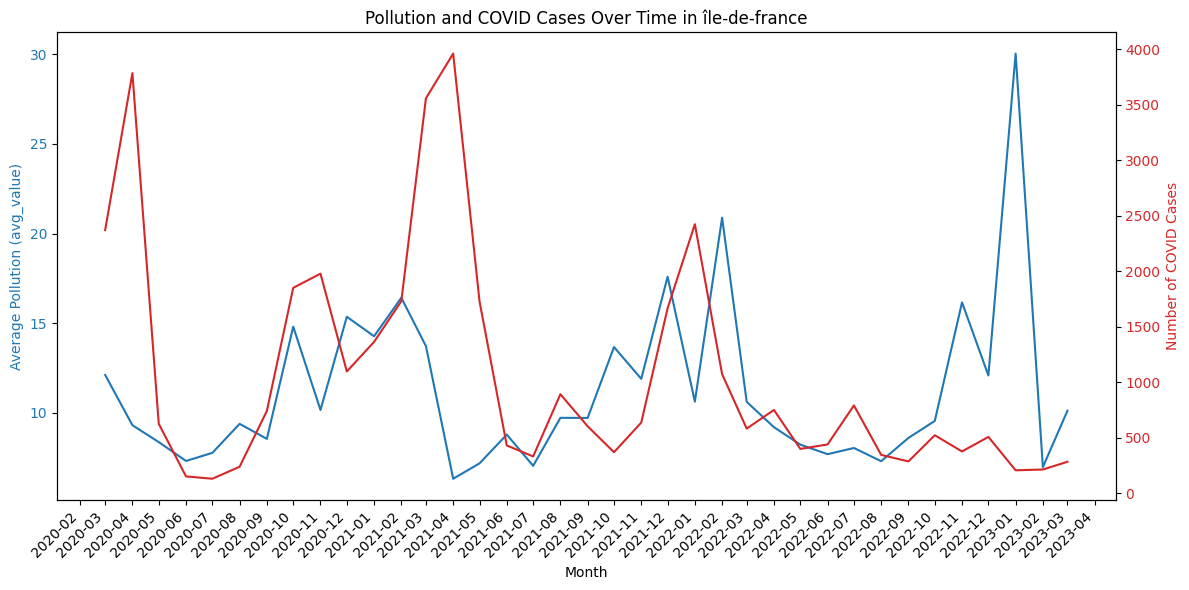

In [8]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

regions = merged_df['region'].unique()

for region in regions:
    region_data = merged_df[merged_df['region'] == region].copy()
    region_data['year_month'] = pd.to_datetime(region_data['year_month'])

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_title(f'Pollution and COVID Cases Over Time in {region}')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Average Pollution (avg_value)', color='tab:blue')
    ax1.plot(region_data['year_month'], region_data['avg_value'], color='tab:blue', label='Pollution (avg_value)')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Show every month on x-axis
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    ax2 = ax1.twinx()
    ax2.set_ylabel('Number of COVID Cases', color='tab:red')
    ax2.plot(region_data['year_month'], region_data['number_of_cases'], color='tab:red', label='COVID Cases')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

    fig.tight_layout()
    plt.show()


/var/folders/nd/m5ygx_wn1pg8b_rwctvdksd80000gn/T/ipykernel_74107/2086392338.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = filtered_df.groupby('region').apply(


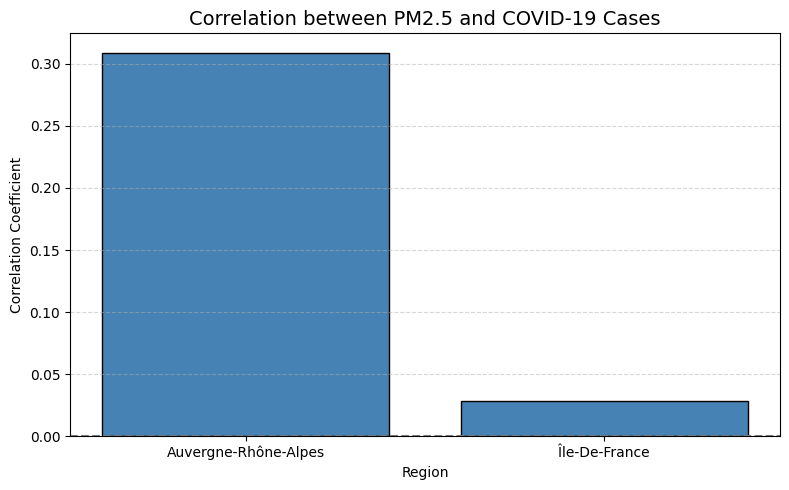

In [9]:

# Keep only the selected regions
target_regions = ['auvergne-rhône-alpes', 'île-de-france']
filtered_df = merged_df[merged_df['region'].isin(target_regions)]

# Calculate correlation between PM2.5 pollution and COVID-19 cases
correlations = filtered_df.groupby('region').apply(
    lambda x: x['avg_value'].corr(x['number_of_cases'])
)

# Plot the correlations for the selected regions
import matplotlib.pyplot as plt

correlations_sorted = correlations.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(correlations_sorted.index.str.title(), correlations_sorted.values, color='steelblue', edgecolor='black')

plt.title('Correlation between PM2.5 and COVID-19 Cases', fontsize=14)
plt.xlabel('Region')
plt.ylabel('Correlation Coefficient')
plt.axhline(0, color='gray', linestyle='--')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
